# Project 1. HMM 적용하여 데이터 모델링 해보기

## Hidden Markov Model

* 은닉마코프모델 계산 및 구현
  * https://ratsgo.github.io/machine%20learning/2017/10/14/computeHMMs/
* https://web.stanford.edu/~jurafsky/slp3/A.pdf
  
## Character Trajactories Data Set
* Import mat-formatted data
  * `mixoutALL_shifted.mat`
* Data Features
  * Data Set Characteristics: Time-Series
  * Number of Instances: 2858
  * Attribute Characteristics: Real
  * Number of Attributes: 3
  * Missing Values? N/A
  * Each character sample is a 3-dimensional pen tip velocity trajectory. This is contained in matrix format, with 3 rows and T columns where T is the length of the character sample.
  * 3 Dimensions were kept - x, y, and pen tip force.
  * http://archive.ics.uci.edu/ml/datasets/Character+Trajectories

In [1]:
from scipy import io
import matplotlib.pyplot as plt
import numpy as np

mat_file = io.loadmat('./Data/mixoutALL_shifted.mat')

# print(mat_file['consts'].dtype)
consts = mat_file['consts'][0,0]
mixouts = mat_file['mixout'][0]

keys = np.squeeze(consts['key'][0])
charlabels = consts['charlabels'][0] - 1

num_keys = keys.size
num_mixouts = mixouts.shape[0]
T = 0

print('num_mixouts:', num_mixouts)
print('num_keys:', num_keys)
for i in range(num_keys):
    print(keys[i], end='')

for i in range(num_mixouts):
    mixouts[i] = mixouts[i].T
    mask = (mixouts[i][:,0] != 0) | (mixouts[i][:,1] != 0)
    mixouts[i] = mixouts[i][mask]
    T = max(T, mixouts[i].shape[0])

num_mixouts: 2858
num_keys: 20
['a']['b']['c']['d']['e']['g']['h']['l']['m']['n']['o']['p']['q']['r']['s']['u']['v']['w']['y']['z']

In [2]:
def plot_disp(disp, time):
    plt.scatter(disp[:time//3,0], disp[:time//3,1], color='blue')
    plt.scatter(disp[time//3:time*2//3,0], disp[time//3:time*2//3,1], color='green')
    plt.scatter(disp[time*2//3:,0], disp[time*2//3:,1], color='red')
#     plt.show()
    
def plot_vel_acc(vel, acc, time):
    plt.subplot('121')
    plt.scatter(vel[:time//3,0], vel[:time//3,1], color='blue')
    plt.scatter(vel[time//3:time*2//3,0], vel[time//3:time*2//3,1], color='green')
    plt.scatter(vel[time*2//3:,0], vel[time*2//3:,1], color='red')
    plt.subplot('122')
    plt.scatter(acc[:time//3,0], acc[:time//3,1], color='blue')
    plt.scatter(acc[time//3:time*2//3,0], acc[time//3:time*2//3,1], color='green')
    plt.scatter(acc[time*2//3:,0], acc[time*2//3:,1], color='red')
    plt.show()    
    
def plot_acc_angle(acc_angle, time):
    plt.plot(range(0,time//3),acc_angle[:time//3], color='blue')
    plt.plot(range(time//3,time*2//3),acc_angle[time//3:time*2//3], color='green')
    plt.plot(range(time*2//3,time),acc_angle[time*2//3:], color='red')
    plt.show()
    
def plot_obs(obs, time):
    plt.plot(range(0,time//3),obs[:time//3], color='blue')
    plt.plot(range(time//3,time*2//3),obs[time//3:time*2//3], color='green')
    plt.plot(range(time*2//3,time),obs[time*2//3:], color='red')
    plt.show()

0 ['a']


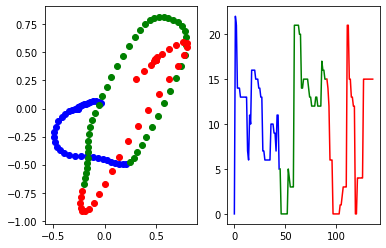

97 ['b']


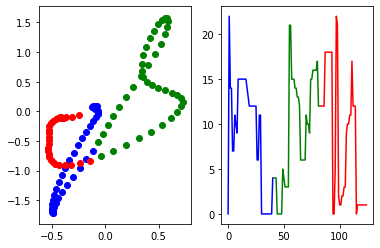

170 ['c']


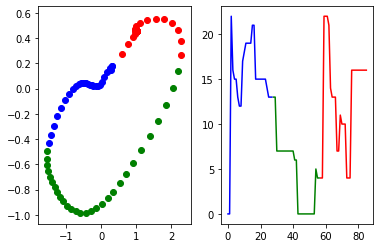

225 ['d']


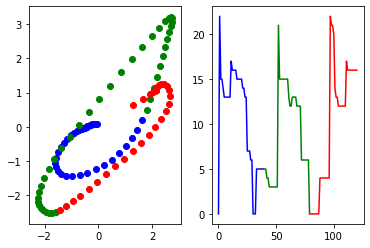

307 ['e']


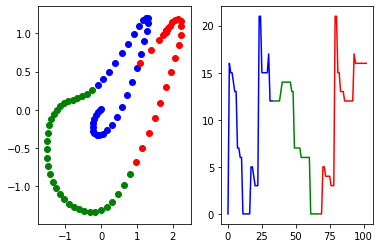

420 ['g']


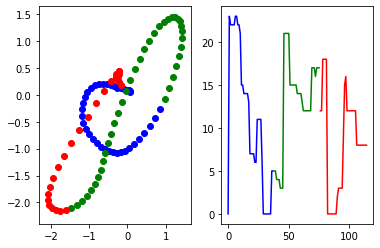

486 ['h']


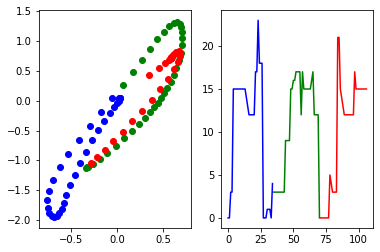

543 ['l']


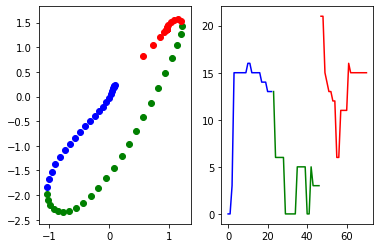

623 ['m']


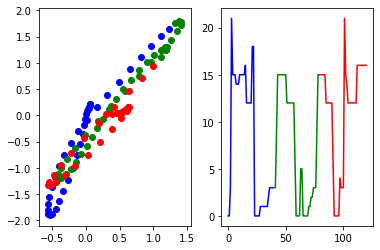

692 ['n']


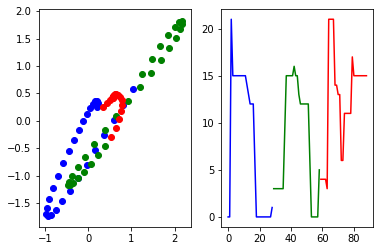

748 ['o']


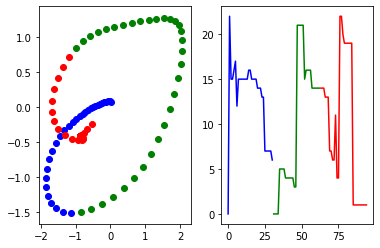

816 ['p']


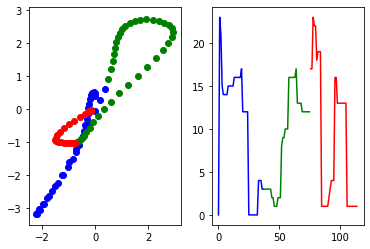

886 ['q']


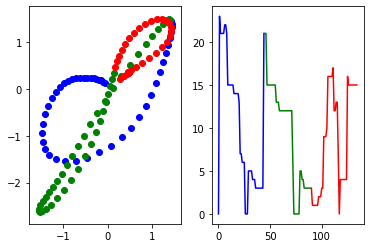

956 ['r']


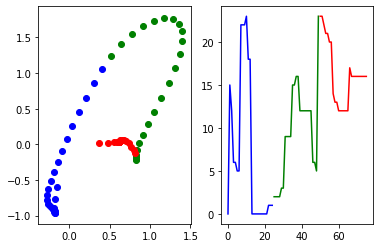

1013 ['s']


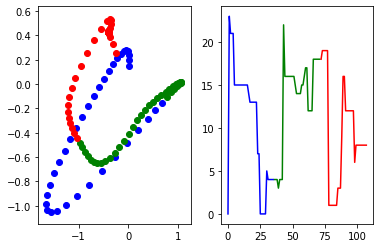

1077 ['u']


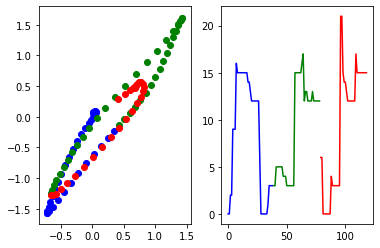

1144 ['v']


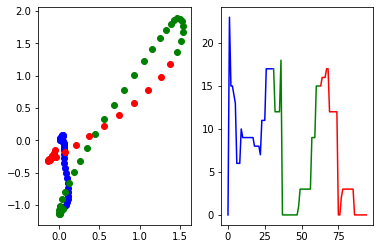

1218 ['w']


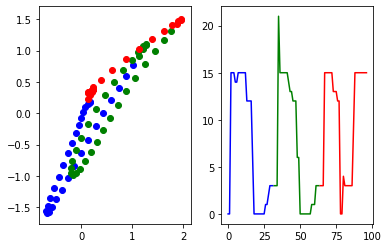

1278 ['y']


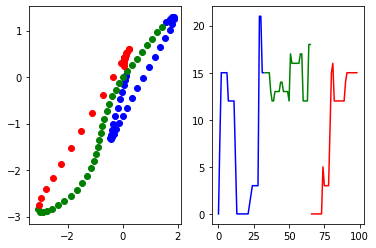

1345 ['z']


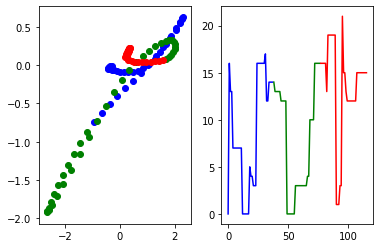

1433 ['a']


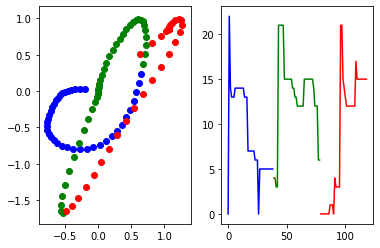

1507 ['b']


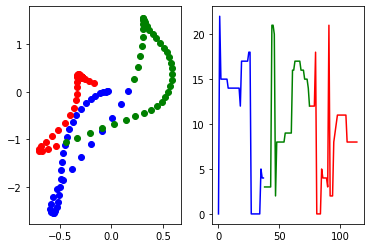

1575 ['c']


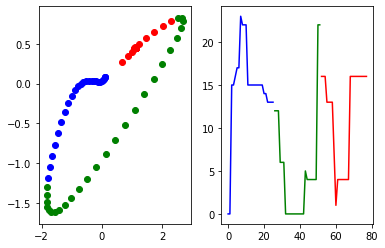

1662 ['d']


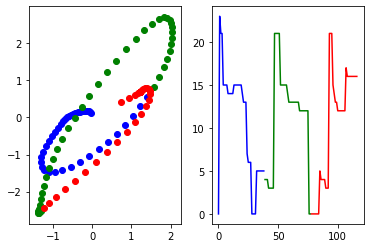

1737 ['e']


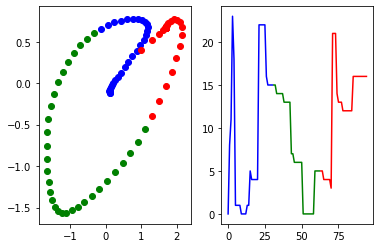

1810 ['g']


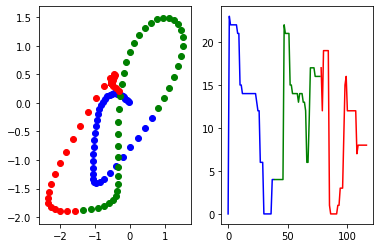

1882 ['h']


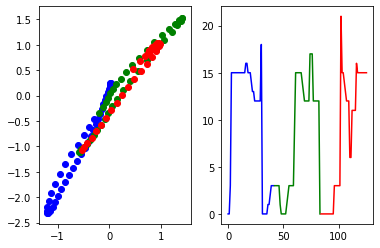

1952 ['l']


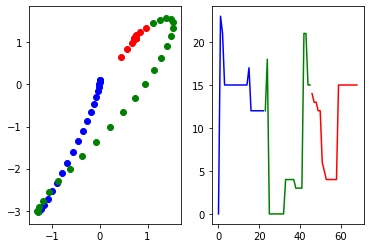

2046 ['m']


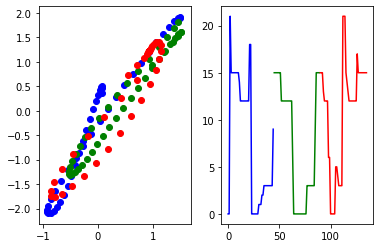

2102 ['n']


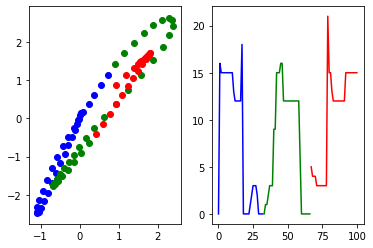

2176 ['o']


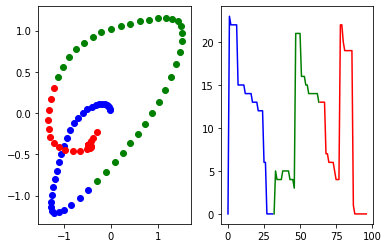

2249 ['p']


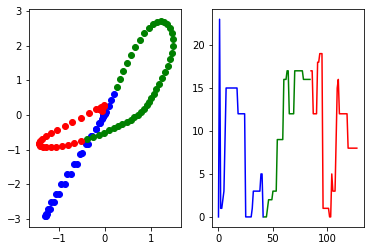

2310 ['q']


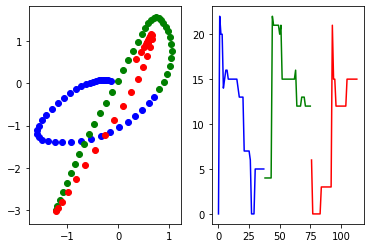

2364 ['r']


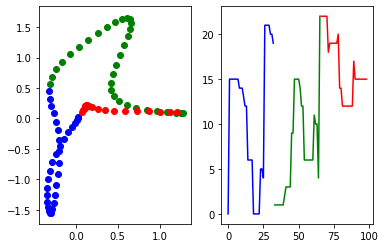

2426 ['s']


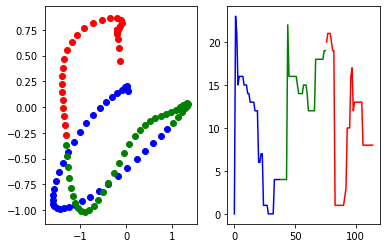

2495 ['u']


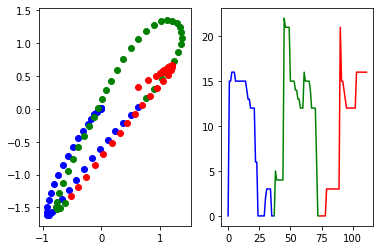

2559 ['v']


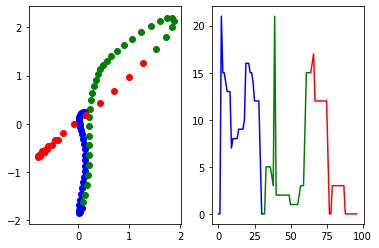

2640 ['w']


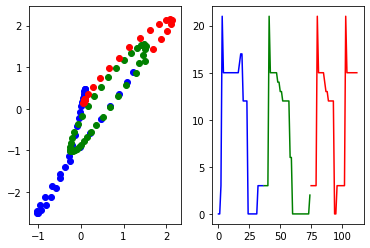

2705 ['y']


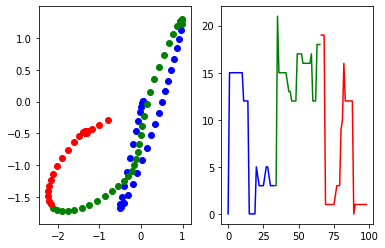

2775 ['z']


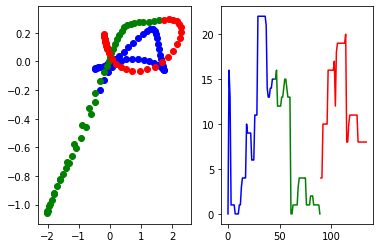

In [4]:
def get_observation(disp):
    time = disp.shape[0]
    vel = np.zeros((time, 2))
    acc = np.zeros((time, 2))
    
    vel_angle = np.zeros(time)
    angle = np.zeros(time)
    obs = np.zeros(time, dtype=int)
    for i in range(1, time):
        vel[i] = disp[i] - disp[i-1]
        acc[i] = vel[i] - vel[i-1]
        vel_angle[i] = np.arctan2(vel[i][0], vel[i][1])
        if vel_angle[i] < 0:
            vel_angle[i] += 2 * np.pi
        angle[i] = np.arctan2(acc[i][0], acc[i][1])
        if angle[i] < 0:
            angle[i] += 2 * np.pi
        obs[i] = int((angle[i] / np.pi * 3) % 6) + int((vel_angle[i] / np.pi * 2) % 4) * 6
    return (time, vel, acc, angle, obs)

num_features = 24
features = np.empty(num_mixouts, dtype=object)
prev = None
for i in range(0, num_mixouts, 1):
    disp = mixouts[i][:,:2]
    (time, vel, acc, angle, obs) = get_observation(disp)
    features[i] = obs
    
    if prev != charlabels[i]:
        print(i, keys[charlabels[i]])
        prev = charlabels[i]
        disp = mixouts[i][:,:2]
        
        plt.subplot('121')
        plot_disp(disp, time)
        
        plt.subplot('122')
        plot_obs(obs, time)
        
#         plot_vel_acc(vel, acc, time)
#         plot_acc_angle(angle, time)

## train_test_split
* `train_size : test_size = 90 : 10`

In [5]:
from sklearn.model_selection import train_test_split

# train, test split
data = np.array([[charlabels[i], features[i][:], i] for i in range(num_mixouts)])
train_data, test_data = train_test_split(data, test_size=0.1)

# sort in charlabel
train_data = train_data[train_data[:, 0].argsort()]
test_data = test_data[test_data[:, 0].argsort()]

print('train:', train_data.shape)
print('test:', test_data.shape)
print(test_data)

train: (2572, 3)
test: (286, 3)
[[0
  array([ 0, 23, 22, 21, 21, 21, 22, 22, 22, 22, 15, 15, 15, 15, 14, 14, 14,
       14, 13, 13, 13, 13,  7,  7,  8,  8,  9,  8,  7,  6,  6,  6,  6,  6,
        0,  0,  0,  0,  5,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  4,  3,  3, 21, 21, 21, 21, 21, 21, 20, 20, 13, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 13, 12, 12, 12, 17, 14, 14, 13, 12, 12, 12,
       12, 12, 12,  6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        5,  4,  4,  4,  4, 22, 21, 21, 21, 15, 14, 13, 13, 13, 13,  7,  6,
       11, 10,  4,  4,  4,  4,  4, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15])
  6]
 [0
  array([ 0, 22, 22, 22, 21, 20, 20, 21, 15, 15, 14, 14, 14, 14, 14, 14, 13,
       13, 13, 13, 13, 13, 13, 13,  7,  7,  7,  7,  7,  7,  7,  6,  6,  0,
        0,  0,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 22, 22,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 15, 15, 15, 15, 15, 14, 14,
       13, 13, 13, 12, 17, 15, 15, 15, 15, 15, 15,

# Character Recognition HMM
## HMM Learn
* `hmmlearn` Tutorial
  * https://hmmlearn.readthedocs.io/en/latest/tutorial.html
* MultinomialHMM API Reference
  * https://hmmlearn.readthedocs.io/en/latest/api.html#multinomialhmm

In [6]:
from hmmlearn import hmm
import time

models = np.empty([num_keys], dtype=object)
idx = np.zeros(num_keys + 1, dtype=int)
for i in range(num_keys):
    models[i] = hmm.MultinomialHMM(n_components=num_features, verbose=False, n_iter=1)

for i in range(train_data.shape[0]):
    idx[train_data[i][0]+1] = i+1;

# multinomial HMM learn
for key in range(num_keys):
    start_time = time.time()
    trainRange = range(idx[key], idx[key+1])
    print('Training', keys[key], 'model w.', idx[key+1]-idx[key], 'examples', end=' ')

    trainX = np.concatenate([train_data[i][1].reshape(-1, 1) for i in trainRange])
    lengths = [len(train_data[i][1]) for i in trainRange]

    models[key].fit(trainX, lengths)
    print("(elapsed time: {}s).".format(time.time() - start_time))

Training ['a'] model w. 152 examples (elapsed time: 3.0301613807678223s).
Training ['b'] model w. 127 examples (elapsed time: 2.4677369594573975s).
Training ['c'] model w. 125 examples (elapsed time: 1.5339748859405518s).
Training ['d'] model w. 143 examples (elapsed time: 2.569286346435547s).
Training ['e'] model w. 166 examples (elapsed time: 2.651658058166504s).
Training ['g'] model w. 127 examples (elapsed time: 2.311516284942627s).
Training ['h'] model w. 115 examples (elapsed time: 1.9165465831756592s).
Training ['l'] model w. 159 examples (elapsed time: 1.662139892578125s).
Training ['m'] model w. 120 examples (elapsed time: 2.5493650436401367s).
Training ['n'] model w. 114 examples (elapsed time: 1.9243998527526855s).
Training ['o'] model w. 128 examples (elapsed time: 2.1565144062042236s).
Training ['p'] model w. 117 examples (elapsed time: 2.1823959350585938s).
Training ['q'] model w. 117 examples (elapsed time: 2.486503839492798s).
Training ['r'] model w. 103 examples (elaps

Wrong Cases
['a'] ['a'] -369.9831909872439 True
['a'] ['a'] -340.875432927826 True
['a'] ['e'] -395.4954447097437 False
['a'] ['e'] -395.4954447097437


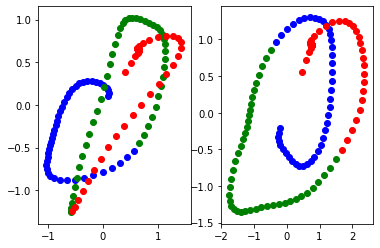

['a'] ['a'] -350.38173854087205 True
['a'] ['a'] -362.9314320720084 True
['a'] ['a'] -346.893958162919 True
['a'] ['a'] -316.95682156180663 True
['a'] ['a'] -400.5218420665217 True
['a'] ['a'] -341.7084909401679 True
['a'] ['d'] -328.3264401980213 False
['a'] ['d'] -328.3264401980213


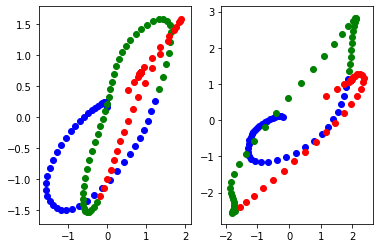

['a'] ['a'] -370.6998700712117 True
['a'] ['a'] -378.47867275214736 True
['a'] ['a'] -382.7623581762596 True
['a'] ['a'] -309.5425186025552 True
['a'] ['a'] -293.2976698263832 True
['a'] ['a'] -408.6489966714197 True
['a'] ['a'] -315.364518901708 True
['a'] ['a'] -379.2786470882245 True
['a'] ['d'] -334.7136319942661 False
['a'] ['d'] -334.7136319942661


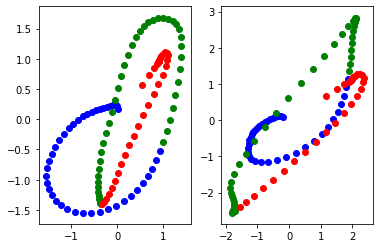

['b'] ['p'] -361.9956586518528 False
['b'] ['p'] -361.9956586518528


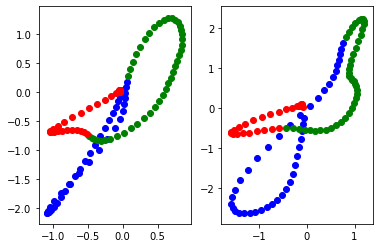

['b'] ['p'] -317.4227215013658 False
['b'] ['p'] -317.4227215013658


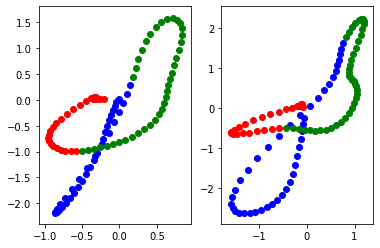

['b'] ['b'] -343.6835504935919 True
['b'] ['b'] -342.12102705361946 True
['b'] ['b'] -382.2775465780583 True
['b'] ['b'] -345.91512290586377 True
['b'] ['y'] -368.1915693200781 False
['b'] ['y'] -368.1915693200781


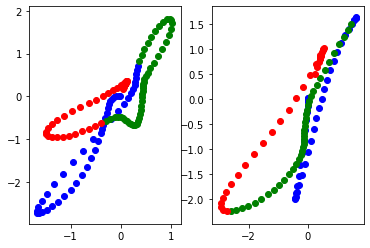

['b'] ['b'] -397.33883266556705 True
['b'] ['p'] -377.17441224877126 False
['b'] ['p'] -377.17441224877126


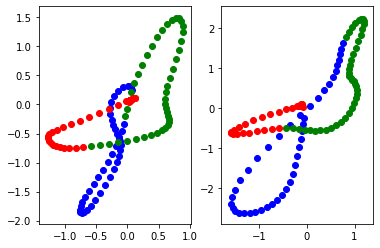

['b'] ['p'] -413.0869671370082 False
['b'] ['p'] -413.0869671370082


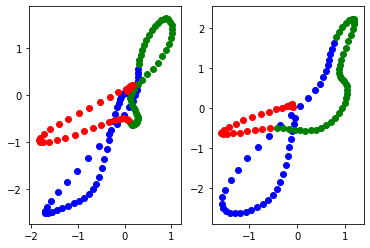

['b'] ['b'] -370.58388705805925 True
['b'] ['b'] -344.4863433974634 True
['b'] ['p'] -413.22918011240023 False
['b'] ['p'] -413.22918011240023


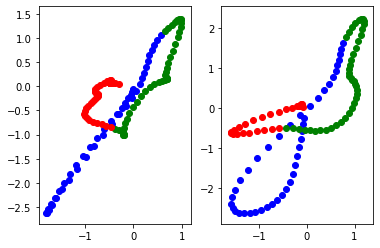

['b'] ['b'] -400.6922667022846 True
['c'] ['c'] -239.89451808837032 True
['c'] ['c'] -203.6983879867814 True
['c'] ['c'] -230.03362809690753 True
['c'] ['g'] -273.68609193727104 False
['c'] ['g'] -273.68609193727104


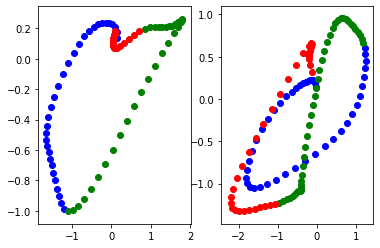

['c'] ['c'] -218.38043797227033 True
['c'] ['c'] -252.55669827817593 True
['c'] ['c'] -213.93673471413 True
['c'] ['c'] -246.25691748177098 True
['c'] ['c'] -251.6491442564118 True
['c'] ['c'] -194.52097511120778 True
['c'] ['z'] -284.333965792065 False
['c'] ['z'] -284.333965792065


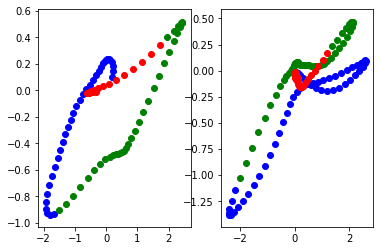

['c'] ['e'] -229.19616417963545 False
['c'] ['e'] -229.19616417963545


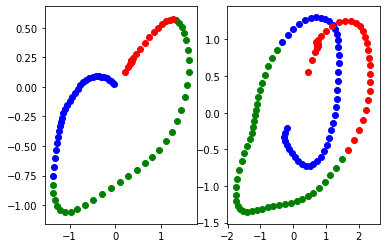

['c'] ['c'] -202.2435662939607 True
['c'] ['z'] -263.7784737509625 False
['c'] ['z'] -263.7784737509625


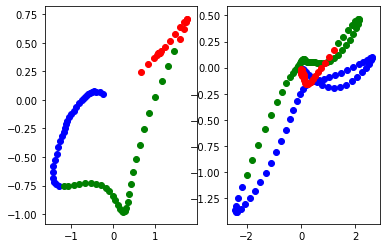

['c'] ['z'] -248.05338039929808 False
['c'] ['z'] -248.05338039929808


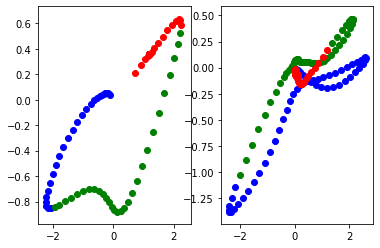

['c'] ['a'] -210.0936914395542 False
['c'] ['a'] -210.0936914395542


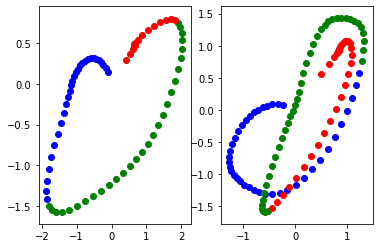

['c'] ['c'] -203.93402035904688 True
['d'] ['d'] -326.6928400414922 True
['d'] ['d'] -294.137906551189 True
['d'] ['d'] -265.18477357235696 True
['d'] ['a'] -335.54508953459157 False
['d'] ['a'] -335.54508953459157


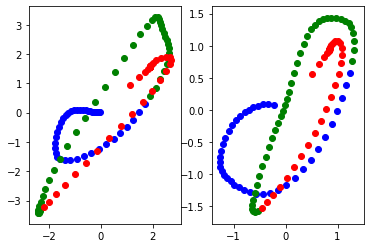

['d'] ['d'] -327.11390964516494 True
['d'] ['u'] -322.4147531735552 False
['d'] ['u'] -322.4147531735552


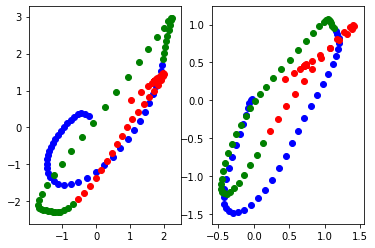

['d'] ['d'] -264.1477003076292 True
['d'] ['d'] -297.74220187183937 True
['d'] ['q'] -367.1972001953631 False
['d'] ['q'] -367.1972001953631


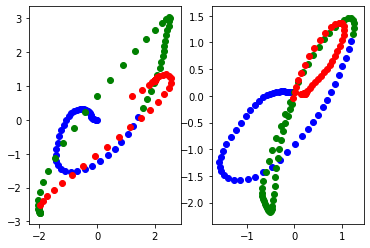

['d'] ['d'] -285.7503012561471 True
['d'] ['d'] -329.7846691554509 True
['d'] ['a'] -323.60851555612703 False
['d'] ['a'] -323.60851555612703


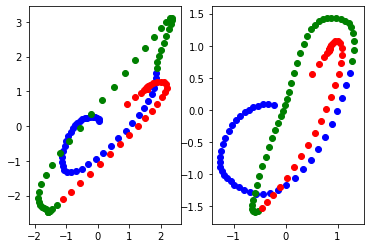

['d'] ['d'] -329.29985087230716 True
['d'] ['d'] -280.47434859189127 True
['e'] ['e'] -285.8846908199264 True
['e'] ['e'] -284.4246513372349 True
['e'] ['e'] -311.3664430887198 True
['e'] ['e'] -304.0900657026425 True
['e'] ['e'] -290.9649799895752 True
['e'] ['e'] -304.72795321074483 True
['e'] ['e'] -286.5494630084147 True
['e'] ['e'] -270.90421287246846 True
['e'] ['e'] -305.2157817786663 True
['e'] ['e'] -261.50057728450577 True
['e'] ['e'] -310.32591911001634 True
['e'] ['e'] -269.22483102792165 True
['e'] ['e'] -302.99573153490275 True
['e'] ['e'] -370.53681462544665 True
['e'] ['e'] -314.9461064565661 True
['e'] ['e'] -356.1399693173842 True
['e'] ['e'] -326.1038460725444 True
['e'] ['e'] -325.5430934135531 True
['e'] ['c'] -324.6455075942164 False
['e'] ['c'] -324.6455075942164


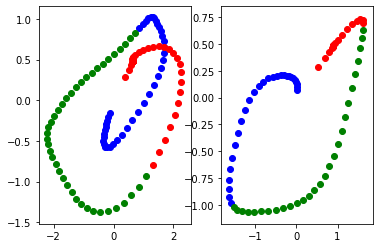

['e'] ['e'] -267.13825666291154 True
['g'] ['g'] -392.08559271867375 True
['g'] ['g'] -400.1131535473265 True
['g'] ['q'] -359.63530020074614 False
['g'] ['q'] -359.63530020074614


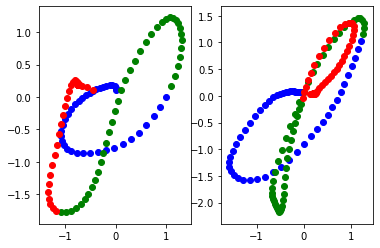

['g'] ['g'] -389.63894146248 True
['g'] ['g'] -379.0657394921734 True
['g'] ['g'] -365.53326671981455 True
['g'] ['g'] -356.12596946559347 True
['g'] ['g'] -342.1546653724865 True
['g'] ['g'] -358.0640539198067 True
['g'] ['g'] -409.5199007294092 True
['g'] ['g'] -419.7825128964303 True
['h'] ['m'] -253.4134232897515 False
['h'] ['m'] -253.4134232897515


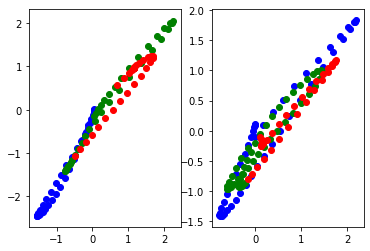

['h'] ['h'] -258.04572803883985 True
['h'] ['h'] -229.11161828411267 True
['h'] ['h'] -305.95829069478157 True
['h'] ['m'] -240.4013792164933 False
['h'] ['m'] -240.4013792164933


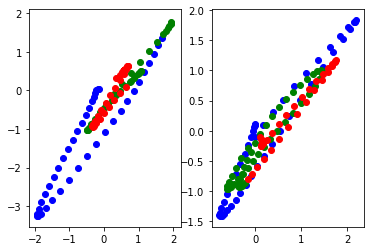

['h'] ['h'] -222.19695207101734 True
['h'] ['n'] -224.78579275438625 False
['h'] ['n'] -224.78579275438625


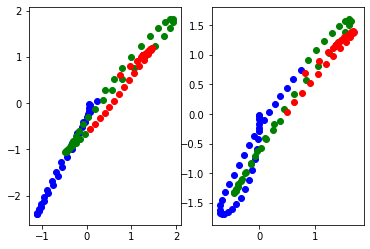

['h'] ['u'] -261.559311035692 False
['h'] ['u'] -261.559311035692


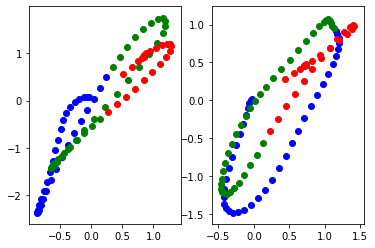

['h'] ['h'] -256.6779127407097 True
['h'] ['m'] -207.66798114985932 False
['h'] ['m'] -207.66798114985932


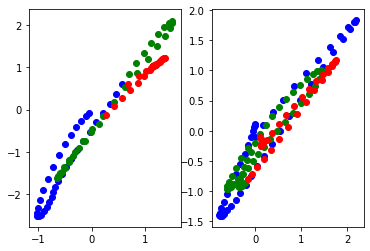

['h'] ['m'] -220.4876119756092 False
['h'] ['m'] -220.4876119756092


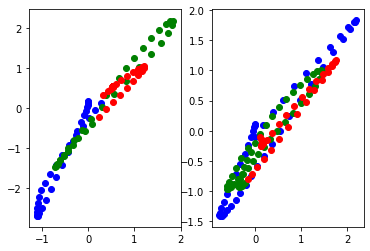

['h'] ['h'] -218.42573305670808 True
['l'] ['q'] -211.54101271814045 False
['l'] ['q'] -211.54101271814045


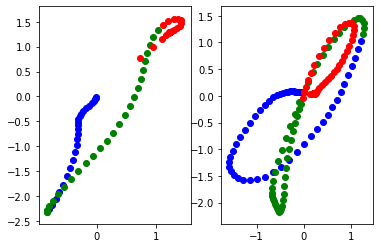

['l'] ['u'] -196.5925828910494 False
['l'] ['u'] -196.5925828910494


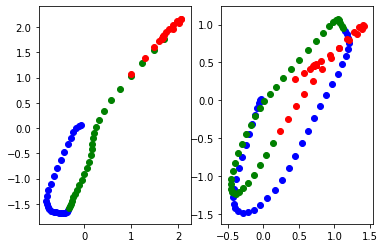

['l'] ['l'] -157.25281809799682 True
['l'] ['l'] -182.95944404277182 True
['l'] ['l'] -181.35519811049818 True
['l'] ['l'] -172.83345354672772 True
['l'] ['w'] -158.65303980596377 False
['l'] ['w'] -158.65303980596377


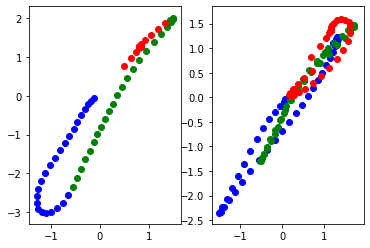

['l'] ['l'] -183.03879593847208 True
['l'] ['m'] -133.28082543054822 False
['l'] ['m'] -133.28082543054822


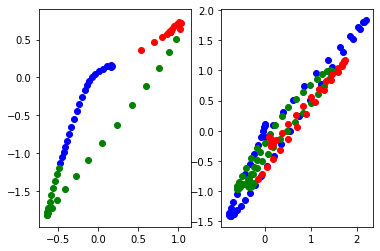

['l'] ['n'] -176.12359773911214 False
['l'] ['n'] -176.12359773911214


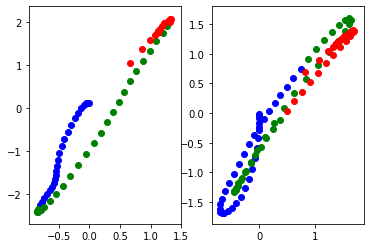

['l'] ['a'] -186.45057636722976 False
['l'] ['a'] -186.45057636722976


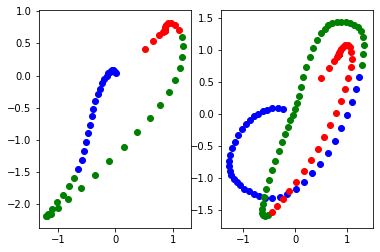

['l'] ['l'] -194.21237914124399 True
['l'] ['y'] -158.07479915110682 False
['l'] ['y'] -158.07479915110682


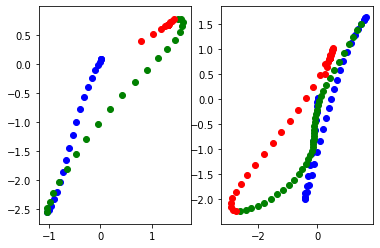

['l'] ['m'] -130.30329688987592 False
['l'] ['m'] -130.30329688987592


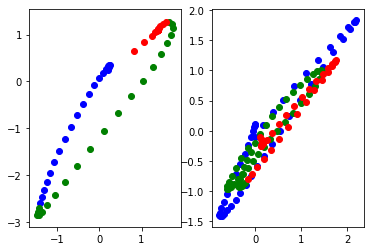

['l'] ['l'] -175.53644262714857 True
['m'] ['m'] -318.56662204437094 True
['m'] ['m'] -349.2159458483283 True
['m'] ['m'] -262.41951789715773 True
['m'] ['n'] -284.4792867723202 False
['m'] ['n'] -284.4792867723202


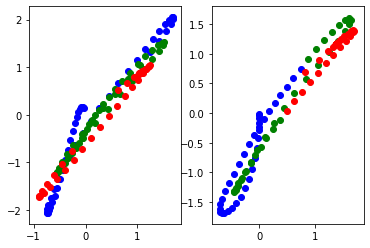

['m'] ['m'] -289.32342341743913 True
['n'] ['m'] -206.23502231243904 False
['n'] ['m'] -206.23502231243904


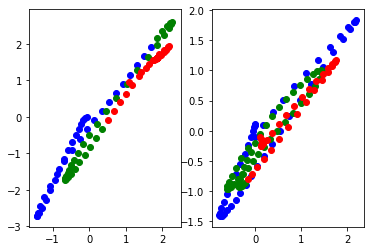

['n'] ['n'] -222.87120647472707 True
['n'] ['n'] -216.9164426239116 True
['n'] ['n'] -255.03277490820435 True
['n'] ['n'] -211.11845317390657 True
['n'] ['m'] -318.2515448300057 False
['n'] ['m'] -318.2515448300057


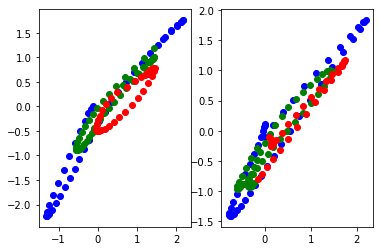

['n'] ['n'] -265.60480351928175 True
['n'] ['h'] -253.246057688851 False
['n'] ['h'] -253.246057688851


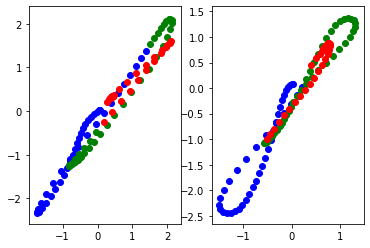

['n'] ['n'] -299.9616407927536 True
['n'] ['h'] -238.80575210034797 False
['n'] ['h'] -238.80575210034797


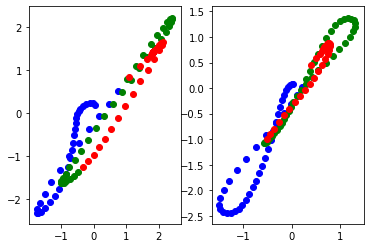

['n'] ['w'] -287.6818439924156 False
['n'] ['w'] -287.6818439924156


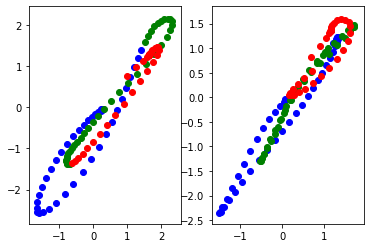

['n'] ['m'] -253.8766919016143 False
['n'] ['m'] -253.8766919016143


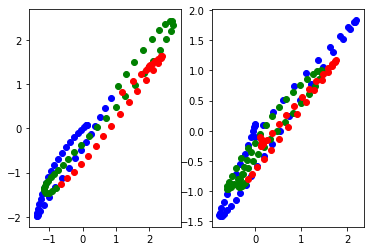

['n'] ['n'] -301.7422984635943 True
['n'] ['n'] -248.83417804198794 True
['n'] ['h'] -327.3999596378898 False
['n'] ['h'] -327.3999596378898


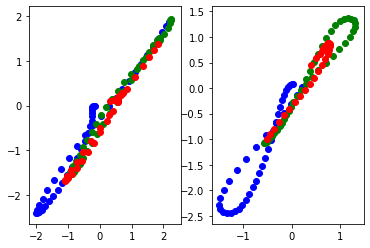

['n'] ['r'] -308.2577777819559 False
['n'] ['r'] -308.2577777819559


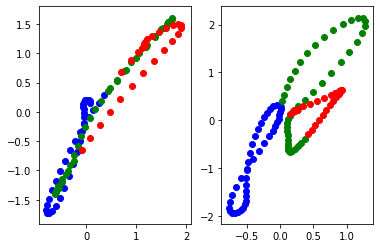

['o'] ['o'] -320.66842370775856 True
['o'] ['o'] -335.2611638385688 True
['o'] ['a'] -325.6672255750644 False
['o'] ['a'] -325.6672255750644


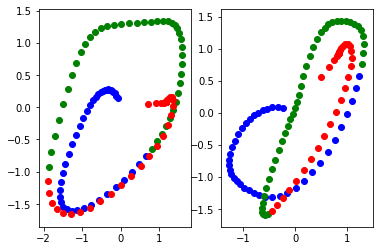

['o'] ['o'] -257.4860446981601 True
['o'] ['o'] -310.04884838168033 True
['o'] ['o'] -279.10967624828754 True
['o'] ['o'] -272.3034791305367 True
['o'] ['o'] -303.1487790541845 True
['o'] ['o'] -325.33260670993 True
['o'] ['o'] -341.5466179701159 True
['o'] ['o'] -273.19603284966183 True
['o'] ['o'] -349.63006054178123 True
['o'] ['e'] -299.77343136648636 False
['o'] ['e'] -299.77343136648636


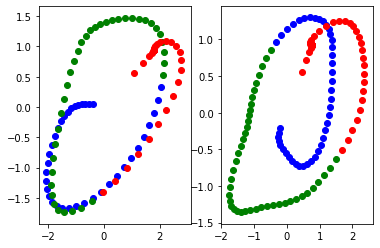

['p'] ['p'] -346.0008120153714 True
['p'] ['p'] -353.87248322837814 True
['p'] ['b'] -364.6799115187759 False
['p'] ['b'] -364.6799115187759


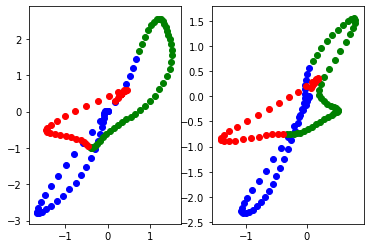

['p'] ['p'] -407.7560944600435 True
['p'] ['p'] -372.21000392574103 True
['p'] ['b'] -325.33649653824403 False
['p'] ['b'] -325.33649653824403


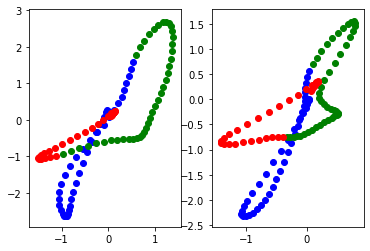

['p'] ['p'] -333.2939830991483 True
['p'] ['p'] -363.96200684225005 True
['p'] ['p'] -357.1345251598072 True
['p'] ['p'] -386.13675719134335 True
['p'] ['p'] -400.9679689078924 True
['p'] ['p'] -350.47387356923525 True
['p'] ['p'] -348.9508990219256 True
['p'] ['p'] -362.66392895362395 True
['q'] ['q'] -469.98008286527386 True
['q'] ['q'] -474.59545012848497 True
['q'] ['v'] -502.62284983277107 False
['q'] ['v'] -502.62284983277107


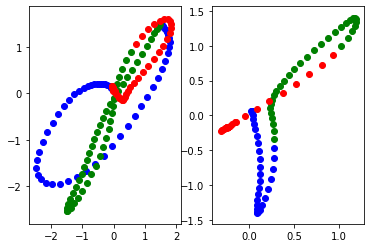

['q'] ['q'] -469.70123570909266 True
['q'] ['q'] -415.01815732265266 True
['q'] ['q'] -460.27439438412995 True
['q'] ['q'] -426.0664771491163 True
['r'] ['r'] -290.17382938844617 True
['r'] ['h'] -315.16045433979025 False
['r'] ['h'] -315.16045433979025


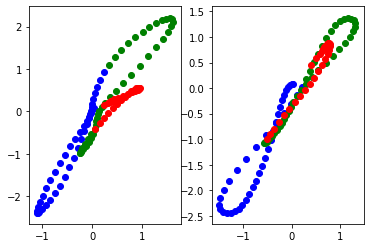

['r'] ['r'] -256.58526566266465 True
['r'] ['b'] -292.74780321023087 False
['r'] ['b'] -292.74780321023087


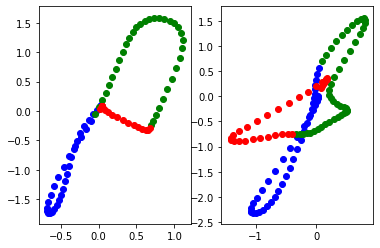

['r'] ['p'] -341.25367010501526 False
['r'] ['p'] -341.25367010501526


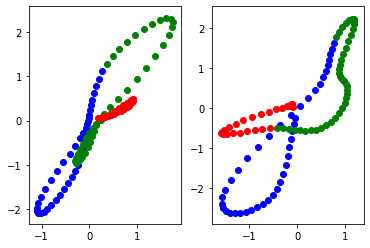

['r'] ['q'] -364.79879080941606 False
['r'] ['q'] -364.79879080941606


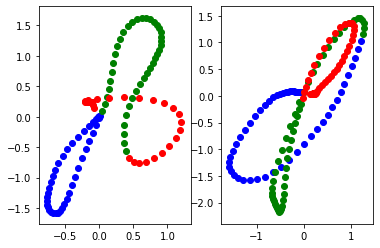

['r'] ['r'] -370.7781104688722 True
['r'] ['r'] -423.845183310746 True
['r'] ['v'] -374.3322160200758 False
['r'] ['v'] -374.3322160200758


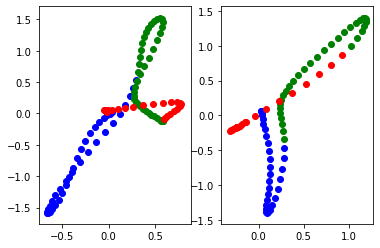

['r'] ['r'] -386.18994688573764 True
['r'] ['r'] -304.2714695798293 True
['r'] ['r'] -340.5309840621634 True
['r'] ['r'] -359.2774606374217 True
['r'] ['r'] -364.6894343214738 True
['r'] ['q'] -488.7348900245349 False
['r'] ['q'] -488.7348900245349


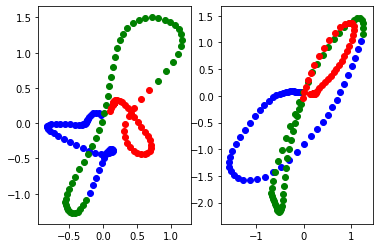

['r'] ['y'] -373.21843415932335 False
['r'] ['y'] -373.21843415932335


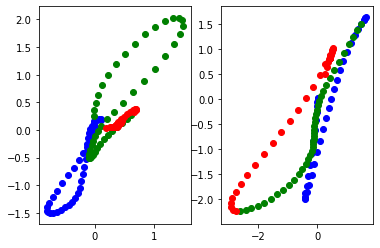

['s'] ['s'] -394.87102591605833 True
['s'] ['s'] -371.4091326461854 True
['s'] ['s'] -347.5926301736581 True
['s'] ['s'] -375.35372919489055 True
['s'] ['s'] -398.25133424844665 True
['s'] ['s'] -342.4233617931297 True
['s'] ['s'] -366.0266938781191 True
['s'] ['s'] -366.4312968708521 True
['s'] ['s'] -403.8793007733103 True
['s'] ['s'] -339.47275993152743 True
['s'] ['s'] -342.0942107770392 True
['s'] ['z'] -353.3583407410359 False
['s'] ['z'] -353.3583407410359


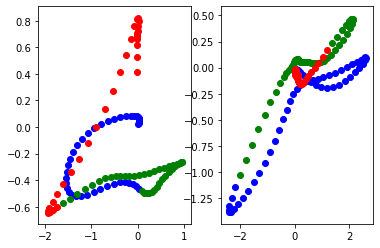

['s'] ['s'] -314.39217273142793 True
['s'] ['s'] -325.8114061278084 True
['u'] ['u'] -303.1620652902461 True
['u'] ['w'] -289.8136128959697 False
['u'] ['w'] -289.8136128959697


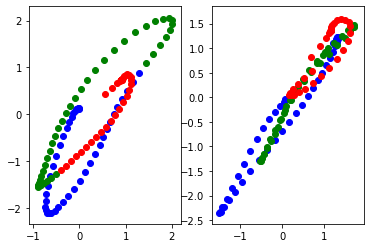

['u'] ['u'] -330.36405433026164 True
['u'] ['u'] -329.19522166475537 True
['u'] ['u'] -283.9407976623946 True
['u'] ['u'] -319.913835692215 True
['u'] ['l'] -345.6744702479209 False
['u'] ['l'] -345.6744702479209


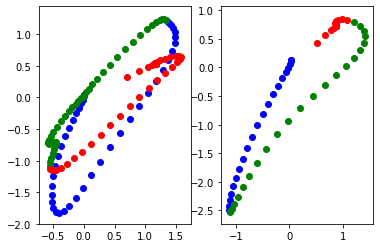

['u'] ['u'] -300.8720189412251 True
['v'] ['v'] -266.59621600766377 True
['v'] ['v'] -320.1766060616735 True
['v'] ['v'] -353.43773151798524 True
['v'] ['v'] -256.5365466610032 True
['v'] ['v'] -280.7308151345432 True
['v'] ['v'] -259.44369081959377 True
['v'] ['v'] -257.9139451381554 True
['v'] ['v'] -295.3767033983362 True
['v'] ['v'] -292.00992588863426 True
['v'] ['v'] -329.1290267964614 True
['v'] ['v'] -248.98644090511917 True
['v'] ['h'] -269.4434261938544 False
['v'] ['h'] -269.4434261938544


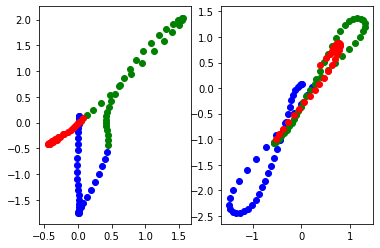

['v'] ['v'] -379.3528103001345 True
['v'] ['v'] -339.5404159333989 True
['v'] ['v'] -289.21593224899436 True
['v'] ['s'] -357.4622396625958 False
['v'] ['s'] -357.4622396625958


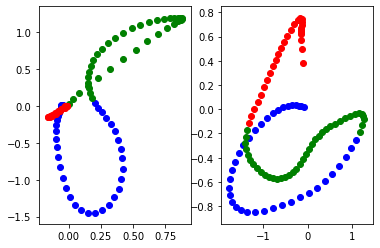

['v'] ['r'] -304.44961692648326 False
['v'] ['r'] -304.44961692648326


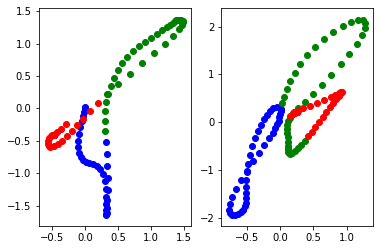

['v'] ['v'] -286.9719895923413 True
['v'] ['v'] -299.2968752400396 True
['v'] ['v'] -308.5208202178749 True
['v'] ['b'] -293.0919711450334 False
['v'] ['b'] -293.0919711450334


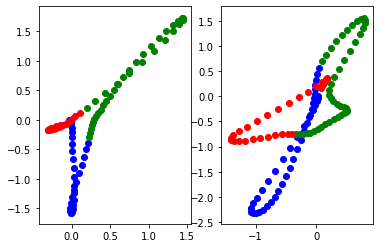

['v'] ['v'] -302.5970657539786 True
['w'] ['m'] -207.88411456113755 False
['w'] ['m'] -207.88411456113755


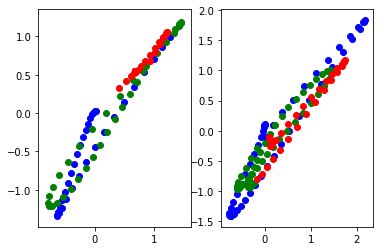

['w'] ['m'] -262.33296755267946 False
['w'] ['m'] -262.33296755267946


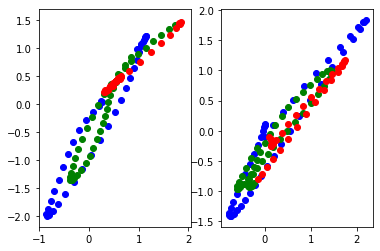

['w'] ['m'] -261.6907841162294 False
['w'] ['m'] -261.6907841162294


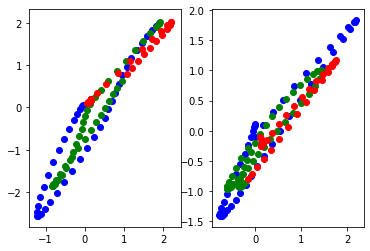

['w'] ['m'] -232.56599229676138 False
['w'] ['m'] -232.56599229676138


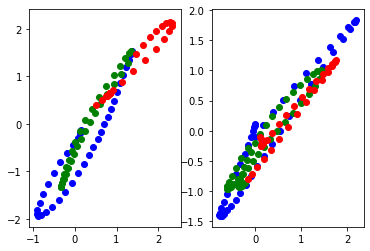

['w'] ['m'] -241.4946017743027 False
['w'] ['m'] -241.4946017743027


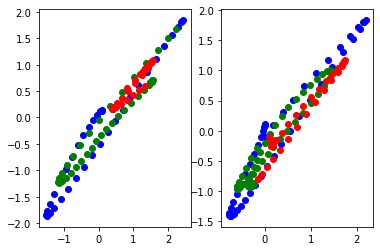

['w'] ['w'] -252.67710092845377 True
['w'] ['w'] -251.15498419736187 True
['w'] ['w'] -256.32890994033033 True
['w'] ['w'] -283.5827632750598 True
['w'] ['m'] -240.6249795242122 False
['w'] ['m'] -240.6249795242122


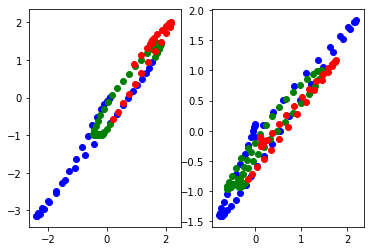

['w'] ['l'] -312.47927553342356 False
['w'] ['l'] -312.47927553342356


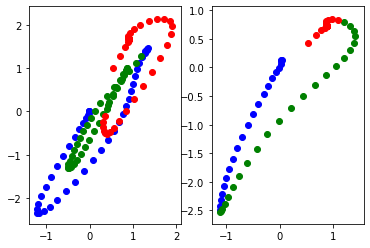

['w'] ['n'] -263.0845526526136 False
['w'] ['n'] -263.0845526526136


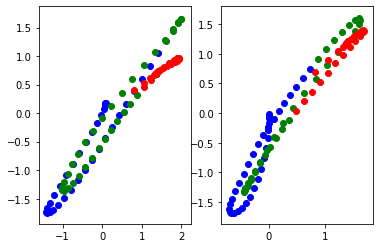

['w'] ['u'] -285.36177691802845 False
['w'] ['u'] -285.36177691802845


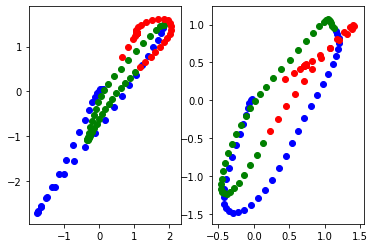

['w'] ['h'] -368.6009104912174 False
['w'] ['h'] -368.6009104912174


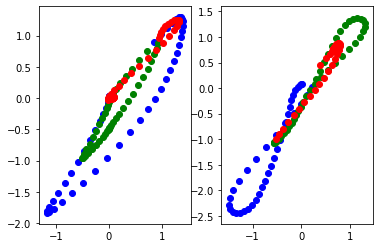

['w'] ['r'] -340.86896078658356 False
['w'] ['r'] -340.86896078658356


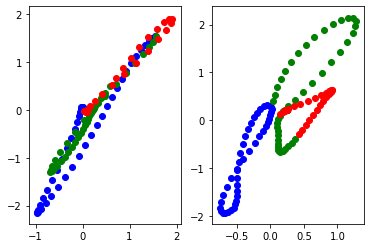

['w'] ['w'] -427.9503274308039 True
['y'] ['y'] -272.0841751641589 True
['y'] ['y'] -300.7845885106664 True
['y'] ['y'] -319.70321242152016 True
['y'] ['p'] -344.8192009183978 False
['y'] ['p'] -344.8192009183978


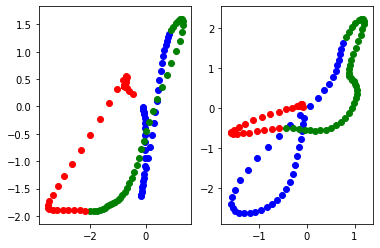

['y'] ['y'] -322.4454085625724 True
['y'] ['n'] -266.6859730874762 False
['y'] ['n'] -266.6859730874762


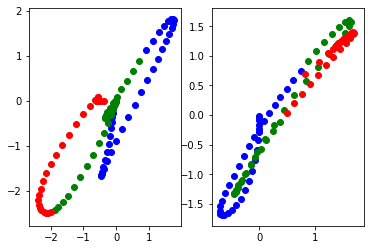

['y'] ['m'] -270.4539842022528 False
['y'] ['m'] -270.4539842022528


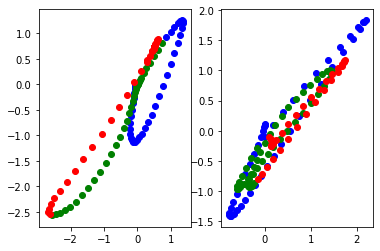

['y'] ['b'] -315.5595642205855 False
['y'] ['b'] -315.5595642205855


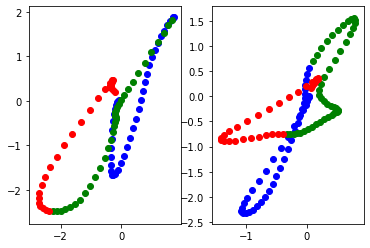

['y'] ['y'] -305.0703160201257 True
['y'] ['h'] -284.45526664720467 False
['y'] ['h'] -284.45526664720467


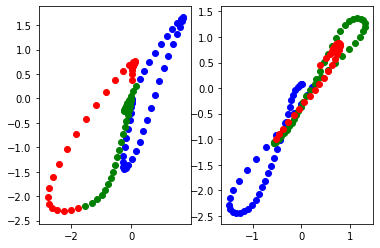

['y'] ['y'] -233.71796618027855 True
['y'] ['b'] -327.0494877554577 False
['y'] ['b'] -327.0494877554577


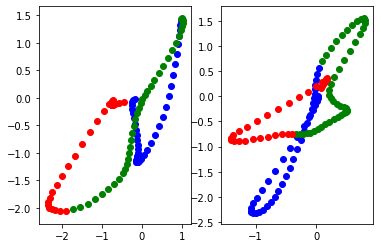

['z'] ['z'] -395.58875083785904 True
['z'] ['z'] -470.04070293427003 True
['z'] ['s'] -412.1075299969442 False
['z'] ['s'] -412.1075299969442


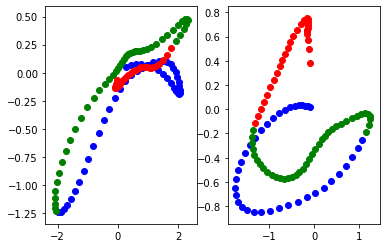

['z'] ['z'] -421.62507936098683 True
['z'] ['z'] -482.03914683854026 True
['z'] ['z'] -456.7292416943623 True
['z'] ['z'] -467.88283978963034 True
['z'] ['z'] -502.39100934849057 True
['z'] ['z'] -410.74169493234496 True
['z'] ['z'] -371.4023994274074 True
['z'] ['z'] -458.95331513572813 True
['z'] ['p'] -409.2003867842454 False
['z'] ['p'] -409.2003867842454


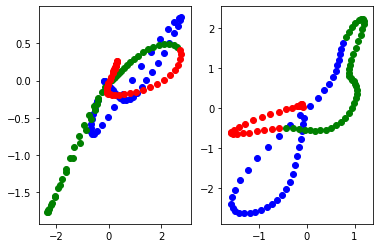

['z'] ['z'] -373.7356818550305 True
['z'] ['z'] -383.4966091680567 True
['z'] ['z'] -432.4676580672184 True
['z'] ['z'] -408.5168931980977 True
['z'] ['z'] -413.2657001756291 True
['z'] ['z'] -424.6817960382378 True
['z'] ['z'] -476.50399868979827 True
['z'] ['z'] -456.7412272197892 True
['z'] ['z'] -382.53582802545776 True
(Wrong, Total) (82, 286)
Accuracy: 71.32867132867133%


In [7]:
testSize = test_data.shape[0]
wrongCases = 0

print('Wrong Cases')
for i in range(testSize):
    testX = np.concatenate([test_data[i][1].reshape(-1, 1)])
    
    maxScore = models[0].score(testX)
    maxKey = 0
    
    for key in range(num_keys):
        score = models[key].score(testX)
        if maxScore < score:
            maxScore = score
            maxKey = key
            
    print(keys[test_data[i][0]], keys[maxKey], maxScore, test_data[i][0] == maxKey)
    
    if not test_data[i][0] == maxKey:
        wrongCases += 1
        disp1 = mixouts[test_data[i][2]][:,:2]
        disp2 = mixouts[train_data[idx[maxKey]][2]][:,:2]
        
        plt.subplot('121')
        plot_disp(disp1, disp1.shape[0])
        
        plt.subplot('122')
        plot_disp(disp2, disp2.shape[0])
        plt.show()
        
print('(Wrong, Total)', (wrongCases, testSize))
print('Accuracy: {}%'.format((1 - wrongCases/testSize) * 100))